In [ ]:
import os
import numpy as np
from matplotlib import pyplot as plt
import cv2
import json

import tensorflow as tf
from tensorflow import keras

from keras import layers
from keras import layers, optimizers
from keras.models import Model
from keras import metrics

In [ ]:
# GPU check
if tf.test.gpu_device_name(): print(tf.test.gpu_device_name())
else: print("None")

# Workspace
workspace = 'C:/Users/andre/OneDrive/Desktop/Siamese Neural Network'
os.chdir(workspace)

# Ignore user warnigs
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Init CascadeClassifier
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# Seed
np.random.seed(42)

# target shape
w, h, ch = 105,105,3
target_shape = (w,h,ch)

/device:GPU:0


## Labeled Faces in the Wild (LFW)

Il dataset utilizzato per il progetto è chiamato Labeled Faces in the Wild [1] Si tratta di un dataset formato da 13233 immagini contenti i volti di 5749 persone diverse. Le persone a cui sono associate due o più immagini sono invece 1680. La struttura del dataset è molto semplice: ad ogni persona è associata una cartella, all'interno della quale sono memorizzate le immagini ad essa relative.

A partire dal dataset LFW è stato creato un secondo dataset chiamato LFW_FF, dove FF sta per Frontal Face. La struttura del nuovo dataset riprende quella dell'originale, tuttavia, ogni immagine è stata preprocessata in modo tale da estrarre soltanto il volto. Ciò è stato reso possibile grazie all’utilizzo di un algoritmo di rilevamento dei volti fornito da OpenCV, chiamato Cascade Classifier [2]. In alcune immagini l’algoritmo non è stato in grado di rilevare il volto, in queste situazioni si è scelto semplicemente di escludere l’immagine dal dataset; più precisamente, sono state prese in considerazione soltanto le immagini al cui interno è stato possibile rilevare un numero di volti pari ad 1.

In [ ]:
if not os.path.exists('lfw_ff'):
    os.mkdir('lfw_ff')

for dir in os.listdir('lfw'):



    for file in os.listdir(os.path.join('lfw', dir)):
        image_path = os.path.join('lfw', dir, file)
        image = cv2.imread(image_path)
        image_gray = cv2.equalizeHist(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))

        faces = face_cascade.detectMultiScale(image_gray, scaleFactor = 1.5, minNeighbors = 5)
        if len(faces) == 1:


            x = faces[0][0]
            y = faces[0][1]
            w = faces[0][2]
            h = faces[0][3]

            width = x + w
            height = y+h
            roi = image[x:x+h, y:y+h]

            if not os.path.exists(os.path.join('lfw_ff', dir)):
                os.mkdir(os.path.join('lfw_ff', dir))

            os.chdir(os.path.join('lfw_ff', dir))
            cv2.imwrite(file, roi)
            os.chdir(workspace)

Il dataset LFW_FF appena generato è formato da 10759 immagini di 4934 persone diverse, mentre le persone a cui sono associate due o più immagini è pari a 1377.

In [ ]:
images = 0
multi_people = 0

for dir in os.listdir('lfw_ff'):
    n = len(os.listdir(os.path.join('lfw_ff', dir)))
    images += n
    if n > 1:
        multi_people+=1

people = len(os.listdir('lfw_ff'))

print('● {} images'.format(images))
print('● {} people'.format(people))
print('● {} people with two or more images'.format(multi_people))

● 10759 images
● 4934 people
● 1377 people with two or more images


Di seguito un'immagine estrattra da LFW e la relativa immagine preprocessata estratta da LFW_FF. Dall'esempio si evince che questa metodologia, oltre che mettere in risalto il volto, permette di eliminare parte degli elementi del background.

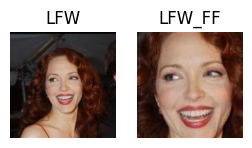

In [ ]:
img = cv2.cvtColor(cv2.imread(os.path.join('lfw', 'Amy_Yasbeck','Amy_Yasbeck_0001.jpg')), cv2.COLOR_BGR2RGB)
img_ff = cv2.cvtColor(cv2.imread(os.path.join('lfw_ff', 'Amy_Yasbeck','Amy_Yasbeck_0001.jpg')), cv2.COLOR_BGR2RGB)

plt.figure(figsize=(3,3))

plt.subplot(1,2, 1)
plt.title("LFW")
plt.axis('off')
plt.imshow(img);

plt.subplot(1,2, 2)
plt.title("LFW_FF")
plt.axis('off')
plt.imshow(img_ff);


## Generazione triple
Le triple sono state generate dal dataset LFW_FF in modo casuale e salvate all'interno di una lista. Ogni tripla è formata da una tupla contenente tre elementi, ovvero i path delle immagini anchor, positive e negative. Ogni cartella contenente più di un'istanza di una persona è stata presa in considerazione per le immagini di riferinemtno (anchors) e per le immagini positive. In particolare, ogni istanza è utilizzata come anchor, mentre l'immagine positiva è scelta casualente fra le restanti istanze. Per completare la tripla viene inserito in modo casuale il path di un'immagine non appartente alla cartella processata, in questo caso sono considerate anche quelle cartelle contenti un'unica istanza di una persona. In questo modo sono state generate 7202 triple.

In [ ]:
def get_tripletes(dataset):

    tripletes =[]
    dirs = os.listdir(dataset)

    for dir in sorted(os.listdir(dataset)):
        files  = os.listdir(os.path.join(dataset, dir))

        anchor_index = 0
        negative_dir = 0
        positive_index = 0
        negative_index = 0

        for i in range(len(files)):

            if len(files) > 2:
                anchor_index = i
                positive_index = i
                while(anchor_index == positive_index):
                    positive_index = np.random.randint(0, len(files))

            elif len(files) == 2:
                anchor_index = i
                positive_index = np.abs(i - 1)

            if anchor_index != positive_index:

                dirs[negative_dir] = dir
                while dirs[negative_dir] == dir:
                    negative_dir = np.random.randint(0, len(dirs))

                files_in_negative_dir = os.listdir(os.path.join(dataset, dirs[negative_dir]))
                negative_index = np.random.randint(0, len(files_in_negative_dir))

                tripletes.append((os.path.join(dir, files[anchor_index]),
                                  os.path.join(dir, files[positive_index]),
                                  os.path.join(dirs[negative_dir], files_in_negative_dir[negative_index])))

    return tripletes

tripletes = get_tripletes('lfw_ff')
print("Tripletes generated: {}".format(len(tripletes)))

Tripletes generated: 7202


Di seguito sono mostrati alcuni esempi delle triple generate dal dataset LFW_FF

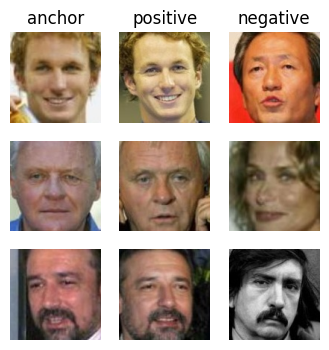

In [ ]:
def print_tripletes(m_rows, dataset, tripletes_list, tripletes_range = 1, img_size = 4):
    plt.figure(figsize=(img_size,img_size))
    n = 3
    for i in range(m_rows):
        for j in range(3):
            if m_rows > 1:
                path = os.path.join(dataset, tripletes_list[i*tripletes_range][j])
            else:
                path = os.path.join(dataset, tripletes_list[tripletes_range][j])

            image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
            index = j+1+i*n
            plt.subplot(m_rows,3, index)
            plt.axis('off')
            if index == 1: plt.title("anchor")
            if index == 2: plt.title("positive")
            if index == 3: plt.title("negative")
            plt.imshow(image);

print_tripletes(3, 'lfw_ff', tripletes, 400)

A partire dalle triple generate sono stati costrutiti il train e il test set. Dove il train set contiene circa il 90% delle triple generate, mentre il test set contiene il restante 10%. Più precisamente il train test è formato da 6282 triple, mentre il test set da 720 triple.

In [ ]:
def split_train_test(tripletes, percentage):
    # init of the train list  (equals to the list of triplets)
    train_list = tripletes[:]
    # init of the test list (empty list)
    test_list = []

    test_size = int(len(tripletes)*percentage/100)

    for i in range(test_size):
        # random index
        index = np.random.randint(0, len(train_list))

         # append the triple corresponding with the genereted index to test list
        test_list.append(train_list[index])

        # remove the same triple to the train list
        train_list.remove(train_list[index])

    return train_list, test_list

train_list, test_list = split_train_test(tripletes, 10)
print("Length train set: {}".format(len(train_list)))
print("Length test set: {}".format(len(test_list)))

Length train set: 6482
Length test set: 720


## Neural Networks
La rete neurale siamese utilizzata contiene tre sotto reti neurali identiche chiamte embedding, questo perché ognuna delle immagini contenute in ogni tripla sarà processata nello stesso momento. La rete embedding di seguito è stata realizzata seguendo il modello descritto nell'articolo [3]

In [ ]:
def get_embedding():
    inp = layers.Input(shape = target_shape, name = 'input_image')

    c1 = layers.Conv2D(64, (10,10), activation='relu')(inp)
    m1 = layers.MaxPooling2D(64, (2,2), padding = 'same')(c1)

    c2 = layers.Conv2D(128, (7,7), activation='relu')(m1)
    m2 = layers.MaxPooling2D(64, (2,2), padding='same')(c2)

    c3 = layers.Conv2D(128, (4,4), activation='relu')(m2)
    m3 = layers.MaxPooling2D(64, (2,2), padding = 'same')(c3)

    c4 = layers.Conv2D(256, (4,4), activation ='relu')(m3)
    f1 = layers.Flatten()(c4)
    d1 = layers.Dense(4096, activation='sigmoid')(f1)

    embedding_model = Model(inputs = [inp], outputs = [d1])

    return embedding_model

embedding_model = get_embedding()
# embedding_model.summary()

Dopo aver ottenuto i vettori delle caratteristiche per ogni immagine della tripla è necessario calcolare la distanza euclidea che separa il vettore ottenuto dall'immagine di riferimento e il vettore ottenuto dall'immagine positiva e la distanza euclidea fra il vettore ottenuto dall'immagine di riferimento e il vettore ottenuto dall'immagine negativa. Per questo compito è stato creato un layer chiamto DistanceLayer [4].

In [ ]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)

Dopodiché le reti embedding per il calcolo del vettore delle caratteristiche e il layer per il calcolo delle distanze sono stati incorportati in quello che è il modello siamese. L'input del modello siamese sono duque le immagini anchor, positive e negative delle triple, mentre l'output le distanze fra i vettori delle caratteristiche. A partire da queste distanze sarà calcolate la funzione triplet loss da minimizzare.

In [ ]:
def get_siamese_model():
    embedding = get_embedding()

    # Inputs
    anchor_input = layers.Input(name = 'anchor_input', shape = target_shape)
    positive_input = layers.Input(name = 'positive_input', shape = target_shape)
    negative_input = layers.Input(name = 'negative_input', shape = target_shape)

    distance_layer = DistanceLayer()

    distances = distance_layer(
        embedding(anchor_input),
        embedding(positive_input),
        embedding(negative_input)
    )

    siamese_model = Model(inputs = [anchor_input, positive_input, negative_input], outputs = distances)

    return siamese_model

siamese_model = get_siamese_model()
siamese_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 anchor_input (InputLayer)      [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 positive_input (InputLayer)    [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 negative_input (InputLayer)    [(None, 105, 105, 3  0           []                               
                                )]                                                          

## Training
Per allenare la rete neurale i path delle immagini contenuti nella lista delle triple sono stati letti mediante la funzione cv2::imread, opportunamente preprocessati e suddivisi in batch.

In [ ]:
def read_image(filepath, normalization = True):
    image = cv2.imread(filepath)
    image = cv2.resize(image, (w,h))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if normalization: image = image/255.0
    return image

def get_batch(data, dataset):
    n = len(data)
    anchor_data = np.zeros((n, w, h, ch))
    pos_data = np.zeros((n, w, h, ch))
    neg_data = np.zeros((n, w, h, ch))
    for i, triplet in enumerate(data):
        anchor_name, pos_name, neg_name = triplet
        anchor_name = os.path.join(dataset, anchor_name)
        pos_name = os.path.join(dataset, pos_name)
        neg_name = os.path.join(dataset, neg_name)

        anchor_data[i] = read_image(anchor_name)
        pos_data[i] = read_image(pos_name)
        neg_data[i] = read_image(neg_name)
    return anchor_data, pos_data, neg_data

Per facilitare la gestione dei risultati ho deciso di creare una classe che permette di leggere e scrivere file di formato json. La seguente classe permette inoltre di creare una lista a partire da una delle chiavi utilizzate per redigire il file.

In [ ]:
class JsonHandling:
    def __init__(self, file_name : str):
        self.file_name = file_name

    def write(self, data):
        with open(self.file_name, 'a') as a:
            json.dump(data, a)
            a.write('\n')

    def read(self):
        with open(self.file_name, "r") as r:
            log = r.read()
            log = log.replace('\n', '')
            log = log.replace('}{', '},{')
            log = "[" + log + "]"
            return json.loads(log)

    def create_list(self, key: str):
        log = self.read()
        list = []
        for i in range(len(log)):
            list.append(log[i][key])
        return list

Dopodiché sono state create due funzioni: una funzione per il trainig della rete e una seconda funzione per calcolare l'accuratezza sui dati di test.

In [ ]:
def test(test_list, n, dataset):
    pos_scores, neg_scores = [], []

    for i in range(int(n / batch_size)):
        start, end = i * batch_size, (i + 1) * batch_size
        anchor, pos, neg = get_batch(test_list[start:end], dataset)
        pred = siamese_model([anchor, pos, neg])
        pos_scores += list(pred[0].numpy())
        neg_scores += list(pred[1].numpy())
    accuracy = np.sum(np.array(pos_scores) < np.array(neg_scores)) / len(pos_scores)

    return accuracy

def train(dataset, filename, epochs, batch_size, margin, modelname):
    log = JsonHandling(filename)
    epoch_losses = []

    for epoch in range(epochs):
        print("\nEPOCH NUMBER: {}".format(epoch))
        losses = []
        for i in range(int(len(train_list)/batch_size)):
            start, end = i*batch_size, (i+1)*batch_size
            anchor, pos, neg = get_batch(train_list[start:end], dataset)
            print('-', end = '')

            with tf.GradientTape() as tape:
                distances = siamese_model([anchor, pos, neg])
                loss = distances[0] - distances[1]
                loss = tf.maximum(loss + margin, 0.0)
            grads = tape.gradient(loss, siamese_model.trainable_weights)
            opt.apply_gradients(zip(grads, siamese_model.trainable_weights))
            losses.append(loss)


        epoch_loss = np.mean(losses)
        print("\nLoss:", np.round(epoch_loss, 3), end = ', ')
        epoch_losses.append(epoch_loss)

        # metrics
        accuracy = test(test_list, len(test_list), dataset)
        print("Accuracy:", np.round(accuracy, 3))

        data = {
            'epoch' : epoch,
            'loss' : float(epoch_loss),
            'accuracy' : float(accuracy)
        }
        log.write(data)

    embedding_model.set_weights(siamese_model.get_weights())
    embedding_model.save(modelname)

    print("\nDone in epoch number {}".format(epoch + 1))

Di seguito sono stati impostati gli ipermarametri ed è stato avviato il traing della rete.

In [ ]:
opt = optimizers.Adam(learning_rate=1e-4)
epochs = 100
batch_size = 32
margin = 0.5
dataset = 'lfw_ff'
filename = 'results.json'
modelname = 'embedding_model_lff.h5'
tripletes = get_tripletes('lfw_ff')
train_list, test_list = split_train_test(tripletes, 10)

train(dataset, filename, epochs, batch_size, margin, modelname)


EPOCH NUMBER: 0
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Loss: 0.497, Accuracy: 0.548

EPOCH NUMBER: 1
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Loss: 0.494, Accuracy: 0.528

EPOCH NUMBER: 2
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Loss: 0.491, Accuracy: 0.584

EPOCH NUMBER: 3
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Loss: 0.489, Accuracy: 0.554

EPO

Di seguito un grafico che mostra l'andamento dell'accuratezza sui dati di test e l'andamento del valore della funzione loss durante il training del modello.

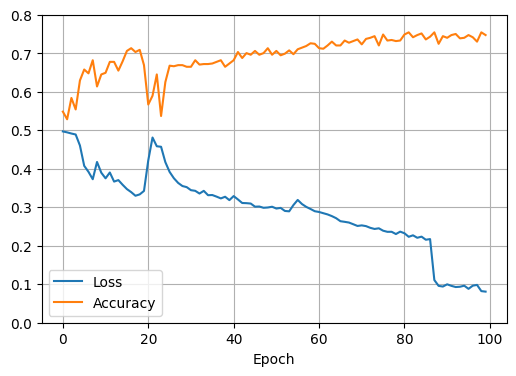

In [ ]:
result = JsonHandling('results.json')

accuracy_list = result.create_list('accuracy')
loss_list = result.create_list('loss')
epoch_list = result.create_list('epoch')

plt.figure(figsize=(6,4))
plt.xlabel('Epoch')
plt.grid()
plt.plot(epoch_list, loss_list, label = 'Loss')
plt.plot(epoch_list, accuracy_list, label = 'Accuracy')
plt.legend()
plt.ylim(0.0, 0.8)
plt.show()


## Testing
Per testare il modello appena allenato è necessario trasformare le immagini delle triple in tensori per essere utilizzate come input del modello. Di seguito due funzioni per facilitare la proceduram, inoltre è stato istanziaziato il modello embedding per l'estrazione dei vettori delle caratteristiche.

In [ ]:
def jpg2tensor(filepath, normalization):
    img = read_image(filepath, normalization)

    tensor = tf.convert_to_tensor(img)
    tensor = tf.expand_dims(tensor, 0)

    return tensor, img

def get_distances(anchor_tensor, positive_tensor,negative_tensor, model):
    anchor_features = model.predict(anchor_tensor)
    positive_features = model.predict(positive_tensor)
    negative_features = model.predict(negative_tensor)

    ap_distance = tf.reduce_sum(tf.square(anchor_features - positive_features), -1)
    an_distance = tf.reduce_sum(tf.square(anchor_features - negative_features), -1)

    cosine_similarity = metrics.CosineSimilarity()
    positive_cosine_similarity = cosine_similarity(anchor_tensor, positive_tensor)
    negative_cosine_similarity = cosine_similarity(anchor_tensor, negative_tensor)

    return ap_distance, an_distance, positive_cosine_similarity, negative_cosine_similarity

embedding_model= tf.keras.models.load_model('embedding_model_lff.h5')

Di seguito due esempi significativi dal test set. Nel primo caso la distanza fra l'immagine anchor e l'immagine positive è davvero bassa, mentre la distanza fra l'immagine anchor e l'immagine negative è molto alta, dunque in questo caso il modello ha prodotto due predizioni esatte. Nel secondo caso mostrato la distanza fra l'immagine anchor e l'immagine positive, seppur bassa, risulta essere maggiore della distanza fra l'immagine anchor e l'immagine negative, dunque in questo caso il modello ha prodotto una predizione sbaglita. Probabilmente questo errore è causato dall'espressione facciale e dall'inclinazione del volto, molto simili nel caso dell'immagine anchor e dell'immagine negative.

1/1 [==============================] - 0s 43ms/step
tf.Tensor([0.33690423], shape=(1,), dtype=float32)
tf.Tensor([8.589772], shape=(1,), dtype=float32)


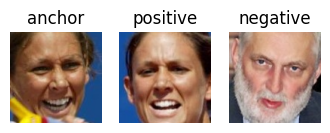

In [ ]:
sample_number = 31

anchor_path = os.path.join('lfw_ff', test_list[sample_number][0])
positive_path = os.path.join('lfw_ff', test_list[sample_number][1])
negative_path = os.path.join('lfw_ff', test_list[sample_number][2])

anchor_tensor, anchor_img = jpg2tensor(anchor_path, True)
positive_tensor, positive_img = jpg2tensor(positive_path, True)
negative_tensor, negative_img = jpg2tensor(negative_path, True)

print_tripletes(1, 'lfw_ff', test_list, sample_number)

ap_distance, an_distance, pos_cos, neg_cos = get_distances(anchor_tensor, positive_tensor, negative_tensor, embedding_model)
print(ap_distance)
print(an_distance)

1/1 [==============================] - 0s 42ms/step
tf.Tensor([2.604146], shape=(1,), dtype=float32)
tf.Tensor([0.57183135], shape=(1,), dtype=float32)


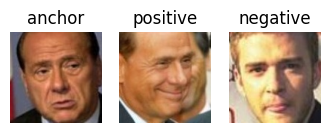

In [ ]:
sample_number = 158

anchor_path = os.path.join('lfw_ff', test_list[sample_number][0])
positive_path = os.path.join('lfw_ff', test_list[sample_number][1])
negative_path = os.path.join('lfw_ff', test_list[sample_number][2])

anchor_tensor, anchor_img = jpg2tensor(anchor_path, True)
positive_tensor, positive_img = jpg2tensor(positive_path, True)
negative_tensor, negative_img = jpg2tensor(negative_path, True)

print_tripletes(1, 'lfw_ff', test_list, sample_number)

ap_distance, an_distance, pos_cos, neg_cos = get_distances(anchor_tensor, positive_tensor, negative_tensor, embedding_model)
print(ap_distance)
print(an_distance)

## Convert into tensorflow lite
L'ultimo step consiste nel convertire il modello prodotto in una versione lite per poter essere implementata all'interno di un dispositov mobile.

In [ ]:
embedding_model = tf.keras.models.load_model('embedding_model_lff.h5')

converter = tf.lite.TFLiteConverter.from_keras_model(embedding_model)
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

## Riferimenti
[1] Labeled Faces in the Wild (http://vis-www.cs.umass.edu/lfw/)

[2] Cascade Classifier (https://docs.opencv.org/3.4/db/d28/tutorial_cascade_classifier.html)

[3] Siamese Neural Networks for One-shot Image Recognition (https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf)

[4] Image similarity estimation using a Siamese Network with a triplet loss (https://keras.io/examples/vision/siamese_network/)